In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analysis_util import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_util import *

import pickle
import seaborn as sns

import itertools


'''this script test the hypothesis whether people respond to a fixed bound
pepole  '''
# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# top level dir 
# 






In [34]:

PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')


In [35]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/permutation_prob_position/")


In [36]:

# Check if the directory exists
if not os.path.exists(FIG_DIR):
    # Create the directory
    os.makedirs(FIG_DIR)
    print(f"Directory '{FIG_DIR}' was created.")
else:
    print(f"Directory '{FIG_DIR}' already exists.")



Directory '/home/jenny/evidence-chain/figs/permutation_prob_position/' already exists.


In [37]:
stimdur = '250'
pos = 0
evaluate_mode = False

In [38]:

list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

if stimdur == '100':
    df = df[df['stimDur'] == 0.1]
if stimdur == '250':
    df = df[df['stimDur'] == 0.25]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]
# df = df[df['stimDur'] == 0.1]



/tmp/ipykernel_651429/100844696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_651429/100844696.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_651429/100844696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [39]:
# correct the count
df = correct_samples_by_condition(df)

cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [40]:
df.shape

(3400, 13)

In [41]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [42]:

# calculate terminated chains
cumsum_stop_list = []

for c in range(cumsum.shape[0]):
    cumsum_stop = cumsum[
        c, : int(count[c]+1)
    ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    cumsum_stop_list.append(cumsum_stop)
 
level_at_response = [i[-1] for i in cumsum_stop_list]
resp = df['key'].tolist()

acc = []
bound = []
for num, k in zip(level_at_response, resp):
    if (num <= 0 and k == 0) or (num >= 0 and k == 1):
        acc.append(1)
    else:
        acc.append(0)
    bound.append(np.abs(num))
df['acc'] = acc
df['bound'] = bound

In [43]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [44]:
# fig, ax = plot_performance_matrix(performance_matrix_test)

In [45]:
# get the chains where 
chain_length = 4




In [46]:
ind = np.sum(~np.isnan(chain_matrix),axis=1)>=chain_length
chain_matrix2 = chain_matrix[ind,:]

valid_ind = np.argmax(np.isnan(chain_matrix2), axis=1) -1

In [47]:
chain_matrix_cumsum = np.cumsum(chain_matrix2, axis=1)

In [48]:
evidence = chain_matrix_cumsum[np.arange(0,len(valid_ind)), valid_ind]

In [49]:
chain_matrix3 = chain_matrix2.copy()
chain_matrix3[evidence<0] = chain_matrix3[evidence<0] * -1

In [50]:
chain_matrix3.shape

(2963, 30)

In [51]:
sequence_cumsum = np.cumsum(sequence, axis=1)
evidence_sequece = sequence_cumsum[:, -1]
sequence2 = sequence.copy()
sequence2[evidence_sequece<0] = sequence2[evidence_sequece<0] * -1

In [52]:
# generate permutations of all possible permutations

In [53]:

# Set the number of elements in each permutation
n = 4

# Generate all permutations of 1 and -1 of length n
perms = list(itertools.product([1, -1], repeat=n))



In [54]:
mydict = {}
evidence_values = []
for target in perms:
    mydict[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        for i in range(len(chain)-target_length+1):
            if tuple(chain[i:i+target_length]) == target:
                occurance +=1
                if i+target_length == ind_stop:
                    term +=1
                    if acc[idx] == 1:
                        term_correct +=1 
    mydict[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    
    

In [55]:



mydict_none = {}
for target in perms:
    mydict_none[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        # within each chain
        for i in range(len(chain)-target_length+1):
            if tuple(chain[i:i+target_length]) == target:
                if chain_cumsum[i+target_length-1]==0:
                    occurance +=1
                    if i+target_length == ind_stop:
                        term +=1
                        if acc[idx] == 1:
                            term_correct +=1 
    mydict_none[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    

In [56]:
# break down by high and low 


position_treshold = 4


mydict_low = {}
for target in perms:
    mydict_low[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        # within each chain
        for i in range(len(chain)-target_length+1):
            if tuple(chain[i:i+target_length]) == target:
                if i<=position_treshold:
                    occurance +=1
                    if i+target_length == ind_stop:
                        term +=1
                        if acc[idx] == 1:
                            term_correct +=1 
    mydict_low[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    
    

In [57]:
# break down by high and low 


mydict_high = {}
for target in perms:
    mydict_high[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        # within each chain
        for i in range(len(chain)-target_length+1):
            if tuple(chain[i:i+target_length]) == target:
                if i>position_treshold:
                    occurance +=1
                    if i+target_length == ind_stop:
                        term +=1
                        if acc[idx] == 1:
                            term_correct +=1 
    mydict_high[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]
    
    

In [58]:
mydict_low

{(1, 1, 1, 1): [1348, 421, 0.31231454005934717, 378, 0.28041543026706234],
 (1, 1, 1, -1): [913, 180, 0.19715224534501644, 166, 0.18181818181818182],
 (1, 1, -1, 1): [1106, 162, 0.14647377938517178, 148, 0.13381555153707053],
 (1, 1, -1, -1): [500, 43, 0.086, 40, 0.08],
 (1, -1, 1, 1): [1257, 235, 0.1869530628480509, 214, 0.17024661893396978],
 (1, -1, 1, -1): [610, 73, 0.11967213114754098, 67, 0.10983606557377049],
 (1, -1, -1, 1): [624, 51, 0.08173076923076923, 46, 0.07371794871794872],
 (1, -1, -1, -1): [212, 0, 0.0, 0, 0.0],
 (-1, 1, 1, 1): [1235, 296, 0.23967611336032388, 272, 0.2202429149797571],
 (-1, 1, 1, -1): [661, 83, 0.12556732223903178, 77, 0.11649016641452345],
 (-1, 1, -1, 1): [638, 55, 0.08620689655172414, 49, 0.0768025078369906],
 (-1, 1, -1, -1): [233, 6, 0.02575107296137339, 6, 0.02575107296137339],
 (-1, -1, 1, 1): [629, 65, 0.10333863275039745, 56, 0.0890302066772655],
 (-1, -1, 1, -1): [240, 5, 0.020833333333333332, 4, 0.016666666666666666],
 (-1, -1, -1, 1): [220

In [59]:
mydict_high

{(1, 1, 1, 1): [1324, 328, 0.24773413897280966, 311, 0.2348942598187311],
 (1, 1, 1, -1): [787, 132, 0.16772554002541296, 129, 0.1639135959339263],
 (1, 1, -1, 1): [826, 94, 0.11380145278450363, 90, 0.1089588377723971],
 (1, 1, -1, -1): [470, 48, 0.10212765957446808, 47, 0.1],
 (1, -1, 1, 1): [927, 129, 0.13915857605177995, 121, 0.13052858683926646],
 (1, -1, 1, -1): [533, 45, 0.08442776735459662, 45, 0.08442776735459662],
 (1, -1, -1, 1): [542, 50, 0.09225092250922509, 47, 0.08671586715867159],
 (1, -1, -1, -1): [240, 18, 0.075, 18, 0.075],
 (-1, 1, 1, 1): [1012, 183, 0.1808300395256917, 178, 0.17588932806324112],
 (-1, 1, 1, -1): [524, 62, 0.1183206106870229, 59, 0.11259541984732824],
 (-1, 1, -1, 1): [577, 49, 0.08492201039861352, 44, 0.07625649913344887],
 (-1, 1, -1, -1): [292, 21, 0.07191780821917808, 19, 0.06506849315068493],
 (-1, -1, 1, 1): [576, 55, 0.0954861111111111, 51, 0.08854166666666667],
 (-1, -1, 1, -1): [275, 17, 0.06181818181818182, 17, 0.06181818181818182],
 (-1, -

In [60]:
def sort_dict(mydict, ind_sorted = None):
    prob = []
    keys= []
    prob_corr =[]
    n_occurences =[]
    for key, values in mydict.items():
        prob.append(values[2])
        keys.append(key)
        prob_corr.append(values[4])
        n_occurences.append(values[0])
    
    if ind_sorted is None:
        ind_sorted = np.argsort(prob)[::-1]
    
    prob=  np.array(prob)
    keys = np.array(keys)    
    prob_corr=  np.array(prob_corr)
    n_occurences=  np.array(n_occurences)

    
    prob_sorted = prob[ind_sorted]
    keys_sorted = keys[ind_sorted]
    prob_corr_sorted = prob_corr[ind_sorted]
    n_occurences_sorted = n_occurences[ind_sorted]
    return  keys_sorted, prob_sorted, prob_corr_sorted, n_occurences_sorted, ind_sorted

/tmp/ipykernel_651429/1984775034.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


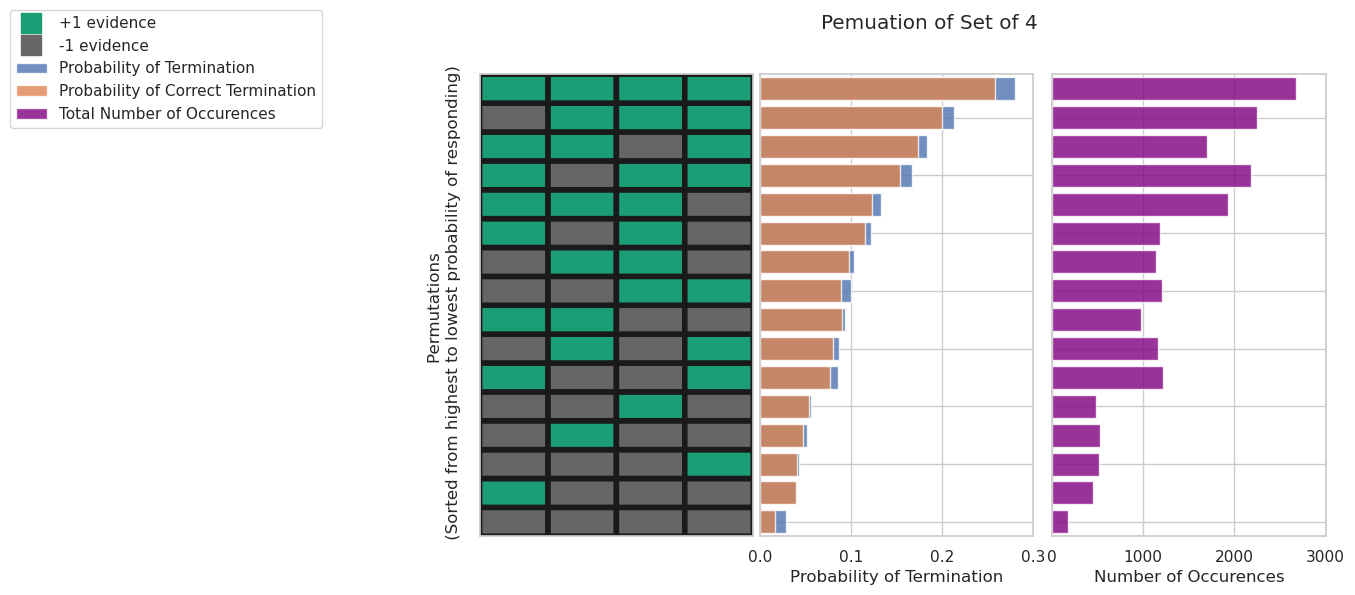

In [61]:

keys_sorted, prob_sorted, prob_corr_sorted, n_occurences_sorted, ind_sorted = sort_dict(mydict)
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize = (12,6))


c = ax0.pcolor(keys_sorted, edgecolors='k', linewidths=4, cmap = 'Dark2')
color1 = c.cmap.colors[0]
color2 = c.cmap.colors[-1]

fig.suptitle(f'Pemuation of Set of {len(keys_sorted[0])}')
ax0.set_ylabel("Permutations \n (Sorted from highest to lowest probability of responding)")
ax1.set_xlabel("Probability of Termination")

ax1.barh(np.arange(0,len(keys_sorted))[::-1], prob_sorted, alpha=0.8,  label = "Probability of Termination")
ax1.barh(np.arange(0,len(keys_sorted))[::-1], prob_corr_sorted,alpha=0.8,  label = "Probability of Correct Termination")

ax2.barh(np.arange(0,len(keys_sorted))[::-1], n_occurences_sorted,alpha=0.8,  label = "Total Number of Occurences", color='purple')
ax2.set_xlabel("Number of Occurences")


ax0.set_yticks = np.arange(0,len(keys_sorted))
ax1.set_ylim(-0.5,len(keys_sorted)-0.5)
ax2.set_ylim(-0.5,len(keys_sorted)-0.5)
ax0.set_yticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax0.set_xticklabels([])

posision = ax1.get_position()
new_pos = [posision.x0-0.04, posision.y0, posision.width, posision.height]
ax1.set_position(new_pos)

posisio2 = ax2.get_position()
new_pos2 = [posisio2.x0-0.07, posisio2.y0, posisio2.width, posisio2.height]
ax2.set_position(new_pos2)

ax1.set_xlim(0,0.3)
ax2.set_xlim(0,3000)

b1, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color1,  label="+1 evidence",)
b2, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color2,  label="-1 evidence")
# fig.legend(handles=[b1, b2],bbox_to_anchor = (0,0))
fig.legend(bbox_to_anchor = (0,1))
fig.show()

fig.savefig(f'{FIG_DIR}permutation_prob_{stimdur}_set{n}_all.png', dpi=300,bbox_inches='tight')


/tmp/ipykernel_651429/3718624654.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


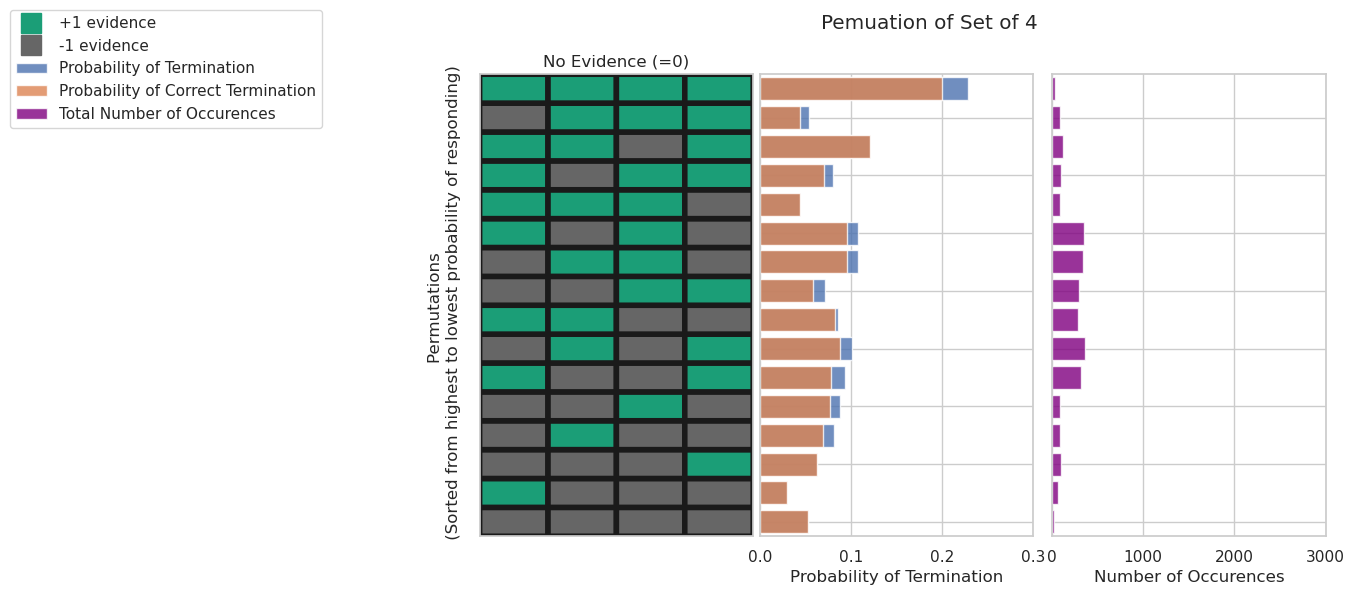

In [62]:
keys_sorted_none, prob_sorted_none, prob_corr_sorted_none, n_occurences_sorted_none,_ = sort_dict(mydict_none, ind_sorted)
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize = (12,6))


c = ax0.pcolor(keys_sorted_none, edgecolors='k', linewidths=4, cmap = 'Dark2')
color1 = c.cmap.colors[0]
color2 = c.cmap.colors[-1]

fig.suptitle(f'Pemuation of Set of {len(keys_sorted_none[0])}')
ax0.set_ylabel("Permutations \n (Sorted from highest to lowest probability of responding)")
ax1.set_xlabel("Probability of Termination")

ax1.barh(np.arange(0,len(keys_sorted_none))[::-1], prob_sorted_none, alpha=0.8,  label = "Probability of Termination")
ax1.barh(np.arange(0,len(keys_sorted_none))[::-1], prob_corr_sorted_none,alpha=0.8,  label = "Probability of Correct Termination")

ax2.barh(np.arange(0,len(keys_sorted_none))[::-1], n_occurences_sorted_none,alpha=0.8,  label = "Total Number of Occurences", color='purple')
ax2.set_xlabel("Number of Occurences")

ax0.set_title(f"No Evidence (=0)")
ax0.set_yticks = np.arange(0,len(keys_sorted_none))
ax1.set_ylim(-0.5,len(keys_sorted_none)-0.5)
ax2.set_ylim(-0.5,len(keys_sorted_none)-0.5)
ax0.set_yticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax0.set_xticklabels([])

posision = ax1.get_position()
new_pos = [posision.x0-0.04, posision.y0, posision.width, posision.height]
ax1.set_position(new_pos)

posisio2 = ax2.get_position()
new_pos2 = [posisio2.x0-0.07, posisio2.y0, posisio2.width, posisio2.height]
ax2.set_position(new_pos2)

ax1.set_xlim(0,0.3)
ax2.set_xlim(0,3000)

b1, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color1,  label="+1 evidence",)
b2, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color2,  label="-1 evidence")
# fig.legend(handles=[b1, b2],bbox_to_anchor = (0,0))
fig.legend(bbox_to_anchor = (0,1))
fig.show()

fig.savefig(f'{FIG_DIR}permutation_prob_{stimdur}_set{n}_no_evidence.png', dpi=300,bbox_inches='tight')

/tmp/ipykernel_651429/1701211320.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


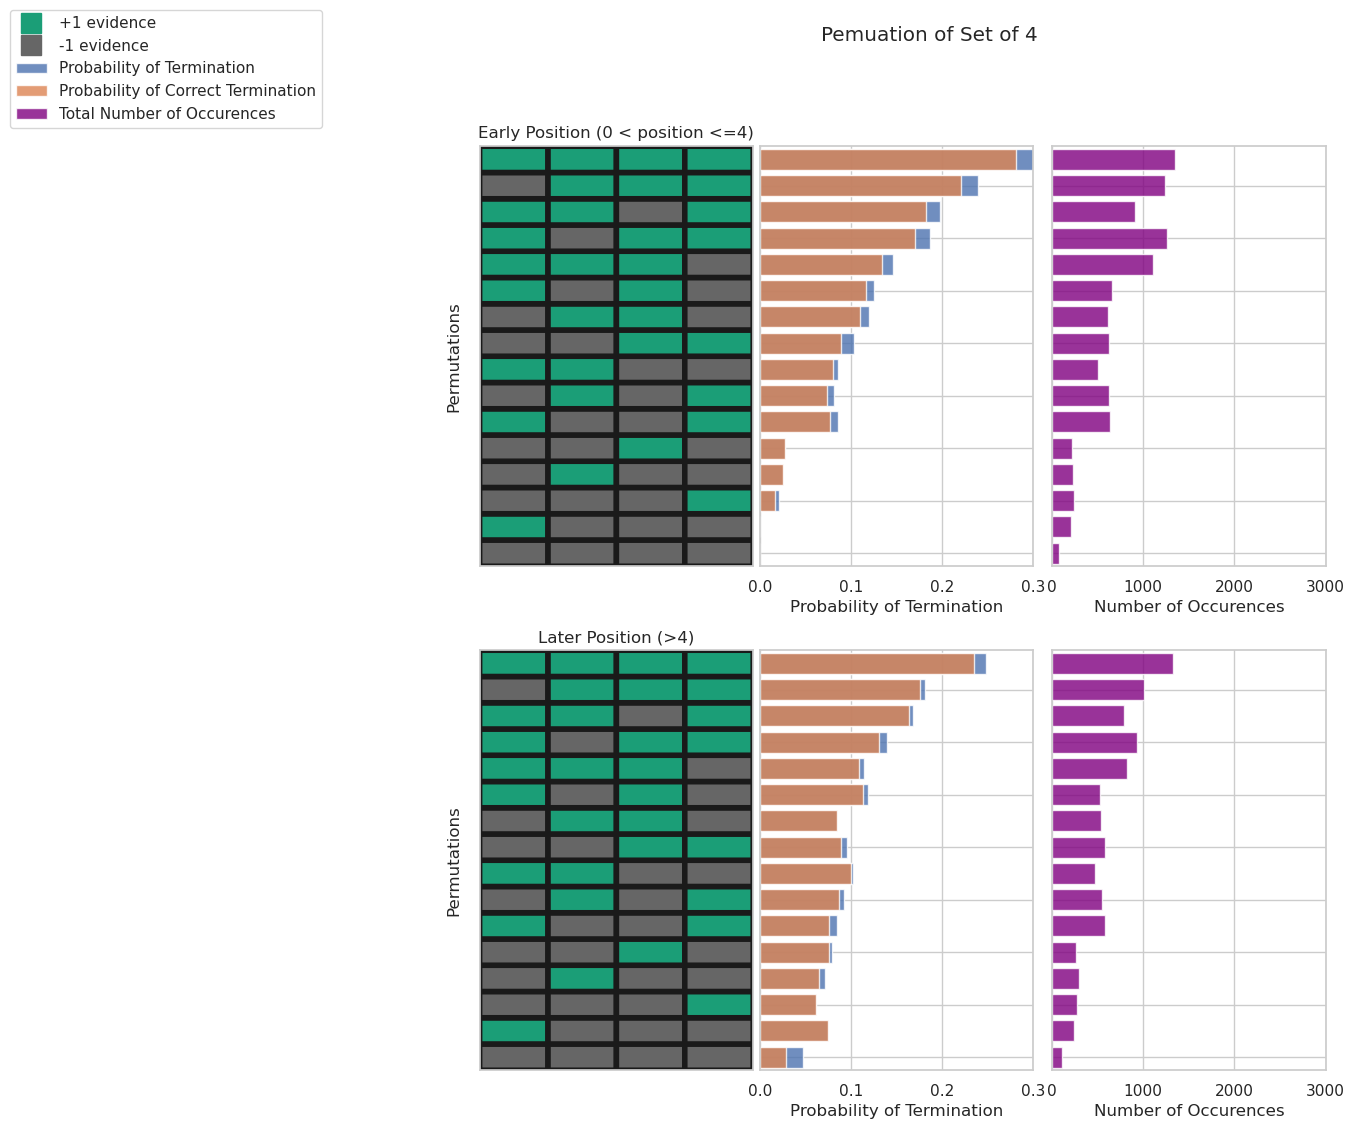

In [65]:
keys_sorted_low, prob_sorted_low, prob_corr_sorted_low, n_occurences_sorted_low, _ = sort_dict(mydict_low, ind_sorted)

keys_sorted_high, prob_sorted_high, prob_corr_sorted_high, n_occurences_sorted_high, _ = sort_dict(mydict_high, ind_sorted)

fig, ax = plt.subplots(2, 3, figsize = (12,12))

ax0,ax1,ax11, ax2,ax3,ax33 = ax.flatten()


c = ax0.pcolor(keys_sorted_low, edgecolors='k', linewidths=4, cmap = 'Dark2')
color1 = c.cmap.colors[0]
color2 = c.cmap.colors[-1]

fig.suptitle(f'Pemuation of Set of {len(keys_sorted_low[0])}')

ax0.set_title(f"Early Position (0 < position <={position_treshold})")
ax0.set_ylabel("Permutations")
ax1.set_xlabel("Probability of Termination")

ax1.barh(np.arange(0,len(keys_sorted_low))[::-1], prob_sorted_low, alpha=0.8,  label = "Probability of Termination")
ax1.barh(np.arange(0,len(keys_sorted_low))[::-1], prob_corr_sorted_low,alpha=0.8,  label = "Probability of Correct Termination")
ax11.barh(np.arange(0,len(keys_sorted_low))[::-1], n_occurences_sorted_low,alpha=0.8,  label = "Total Number of Occurences", color='purple')
ax11.set_xlabel("Number of Occurences")


ax0.set_yticks = np.arange(0,len(keys_sorted_low))
ax1.set_ylim(-0.5,len(keys_sorted_low)-0.5)
ax11.set_ylim(-0.5,len(keys_sorted_low)-0.5)
ax0.set_yticklabels([])
ax1.set_yticklabels([])
ax0.set_xticklabels([])
ax11.set_yticklabels([])


posision = ax1.get_position()
new_pos = [posision.x0-0.04, posision.y0, posision.width, posision.height]
ax1.set_position(new_pos)
ax1.set_xlim(0,0.3)

posisio11 = ax11.get_position()
new_pos11 = [posisio11.x0-0.07, posisio11.y0, posisio11.width, posisio11.height]
ax11.set_position(new_pos11)


c1 = ax2.pcolor(keys_sorted_high, edgecolors='k', linewidths=4, cmap = 'Dark2')

ax2.set_title(f"Later Position (>{position_treshold})")

ax2.set_ylabel("Permutations")
ax3.set_xlabel("Probability of Termination")

ax3.barh(np.arange(0,len(keys_sorted_high))[::-1], prob_sorted_high, alpha=0.8)
ax3.barh(np.arange(0,len(keys_sorted_high))[::-1], prob_corr_sorted_high,alpha=0.8)

ax33.barh(np.arange(0,len(keys_sorted_high))[::-1], n_occurences_sorted_high, alpha=0.8,  color='purple')
ax33.set_xlabel("Number of Occurences")

ax2.set_yticks = np.arange(0,len(keys_sorted_high))
ax3.set_ylim(-0.5,len(keys_sorted_high)-0.5)
ax33.set_ylim(-0.5,len(keys_sorted_low)-0.5)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax2.set_xticklabels([])
ax33.set_yticklabels([])

posision = ax3.get_position()
new_pos = [posision.x0-0.04, posision.y0, posision.width, posision.height]
ax3.set_position(new_pos)
ax3.set_xlim(0,0.3)
ax11.set_xlim(0,3000)

ax33.set_xlim(0,3000)



posisio33 = ax33.get_position()
new_pos33 = [posisio33.x0-0.07, posisio33.y0, posisio33.width, posisio33.height]
ax33.set_position(new_pos33)



b1, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color1,  label="+1 evidence",)
b2, =ax0.plot([], marker="s", markersize=15, linestyle="", color=color2,  label="-1 evidence")
# fig.legend(handles=[b1, b2],bbox_to_anchor = (0,0))
fig.legend(bbox_to_anchor = (0,1))
fig.show()

fig.savefig(f'{FIG_DIR}permutation_prob_{stimdur}_set{n}_by_evidence.png', dpi=300,bbox_inches='tight')

In [64]:
# probability as a function of evidence 


mydict = {}
evidence_values = []
for target in perms:
    mydict[target] = None
    target_length = len(target)
    occurance =  0
    term = 0
    term_correct = 0
    for idx, chain in enumerate(chain_matrix3):
        ind_stop = np.argmax(np.isnan(chain))
        chain_cumsum = np.cumsum(chain)
        for i in range(len(chain)-target_length+1):
            if tuple(chain[i:i+target_length]) == target:
                occurance +=1
                if i+target_length == ind_stop:
                    term +=1
                    if acc[idx] == 1:
                        term_correct +=1 
    mydict[target] = [occurance, term, term/occurance, term_correct, term_correct/occurance]